In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#Plot
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

testData = pd.read_csv("test.csv")
testY = pd.read_csv("output.csv")
testData['stroke'] = testY['stroke']
trainData = pd.read_csv("train.csv")

#Not Significant for Strokes

trainData = trainData.drop( columns=['ever_married', 'gender'] )
testData = testData.drop( columns=['ever_married', 'gender'] )

#Filling Missing BMI Data === train

temp = trainData['bmi'].mean() + trainData['bmi'].median()
temp /= 2
temp
trainData['bmi'] = trainData['bmi'].fillna(temp)

#Filling Missing BMI Data ===test

temp = testData['bmi'].mean() + testData['bmi'].median()
temp /= 2
temp
testData['bmi'] = testData['bmi'].fillna(temp)

# Segregating into Two Models Smoking & Non-Smoking

trainDataNS = trainData[ trainData['smoking_status'].isna() ]
trainDataNS = trainDataNS.drop( columns=['smoking_status'] )
trainDataS = trainData[ trainData['smoking_status'].notna() ]

testDataNS = testData[ testData['smoking_status'].isna() ]
testDataNS = testDataNS.drop( columns=['smoking_status'] )
testDataS = testData[ testData['smoking_status'].notna() ]

# X and Y division

yTrainDataNS = trainDataNS['stroke']
xTrainDataNS = trainDataNS.drop( columns=['stroke'] )

yTrainDataS = trainDataS['stroke']
xTrainDataS = trainDataS.drop( columns=['stroke'] )

yTestDataNS = testDataNS['stroke']
xTestDataNS = testDataNS.drop( columns=['stroke'] )

yTestDataS = testDataS['stroke']
xTestDataS = testDataS.drop( columns=['stroke'] )

#Nominal Categories to one-hot encoding === Train

#Smoke Data
xTrainDataS = pd.get_dummies( xTrainDataS, 
                             columns=[ 'work_type' , 'Residence_type', 'smoking_status']
                            , prefix= ['work_type' , 'res_type', 'smoke'] )


#No Smoke Data
xTrainDataNS = pd.get_dummies( xTrainDataNS,
                              columns=[ 'work_type' , 'Residence_type']
                            , prefix=['[work_type' , 'res_type'] )

#Nominal Categories to one-hot encoding ===Test

#Smoke Data
xTestDataS = pd.get_dummies( xTestDataS,
                            columns=['work_type' , 'Residence_type', 'smoking_status']
                            , prefix=['work_type' , 'res_type', 'smoke'] )


#No Smoke Data
xTestDataNS = pd.get_dummies( xTestDataNS,
                             columns=['work_type' , 'Residence_type']
                            , prefix=['work_type' , 'res_type'] )

smokeCol = xTrainDataS.columns
nsmokeCol = xTrainDataNS.columns

In [36]:
print(xTrainDataS.shape)
print(yTrainDataS.shape)

(30108, 16)
(30108,)


In [44]:
#Sampling for removing imbalance

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)

xTrainDataNS, yTrainDataNS = smote.fit_sample(xTrainDataNS, yTrainDataNS)
xTrainDataS, yTrainDataS = smote.fit_sample(xTrainDataS, yTrainDataS)

xTrainDataS = pd.DataFrame( xTrainDataS , columns=smokeCol )
xTrainDataNS = pd.DataFrame( xTrainDataNS , columns=nsmokeCol )
yTrainDataS = pd.DataFrame( yTrainDataS , columns=['stroke'])
yTrainDataNS = pd.DataFrame( yTrainDataNS , columns=['stroke'])

In [28]:
print(xTrainDataS.shape)
print(yTrainDataS.shape)

(58940, 16)
(58940, 1)


In [45]:
from sklearn.model_selection import train_test_split

#Train Splitter

x_train, x_test, y_train, y_test = train_test_split(xTrainDataNS, np.ravel( yTrainDataNS , order='C' )  , test_size=0.35, random_state=0)

x_trainS, x_testS, y_trainS, y_testS = train_test_split(xTrainDataS, np.ravel( yTrainDataS , order='C' ), test_size=0.35, random_state=0)

In [49]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

model = LogisticRegression(solver='lbfgs', max_iter=400)
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(x_train, y_train)
# summarize the selection of the attributes
print('Selected features: %s' % list(x_train.columns[rfe.support_]))



Selected features: ['age', 'hypertension', 'heart_disease', '[work_type_Govt_job', '[work_type_Never_worked', '[work_type_children', 'res_type_Rural', 'res_type_Urban']


Optimal number of features: 15
Selected features: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'res_type_Rural', 'res_type_Urban', 'smoke_formerly smoked', 'smoke_never smoked', 'smoke_smokes']


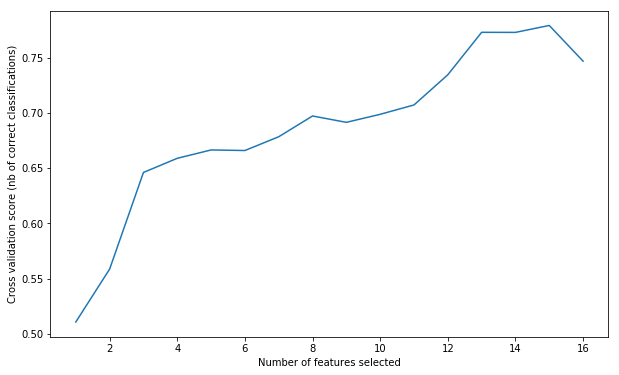

In [50]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(solver='lbfgs'), step=1, cv=10, scoring='accuracy')
rfecv.fit(xTrainDataS, yTrainDataS)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(xTrainDataS.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

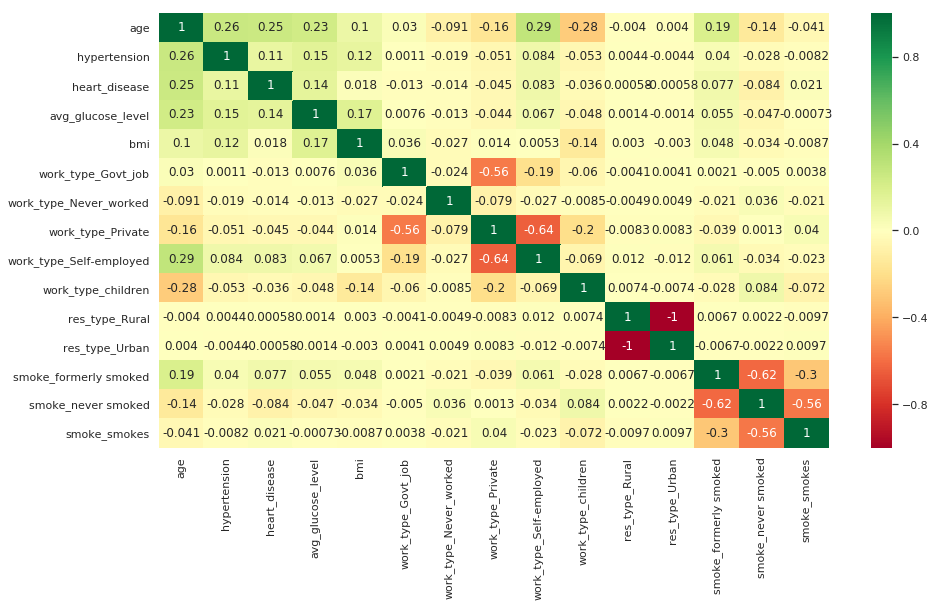

In [55]:
Selected_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'work_type_Govt_job',
                    'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
                    'work_type_children', 'res_type_Rural', 'res_type_Urban', 'smoke_formerly smoked', 
                    'smoke_never smoked', 'smoke_smokes']
X = xTrainDataS[Selected_features]
Xtest = xTestDataS[Selected_features]
plt.subplots(figsize=(15, 8))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

In [58]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

X_train, X_test, y_train, y_test = train_test_split(X, yTrainDataS, test_size=0.2, random_state=2)


Train/Test split results:
LogisticRegression accuracy is 0.977
LogisticRegression log_loss is 0.091
LogisticRegression auc is 0.845


/home/ncheck/anaconda3/envs/deepenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


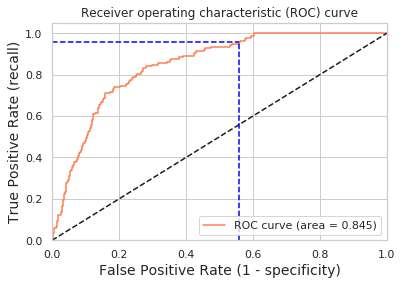

Using a threshold of 0.007 guarantees a sensitivity of 0.957 and a specificity of 0.442, i.e. a false positive rate of 55.81%.


In [64]:
# check classification scores of logistic regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [60]:
# 10-fold cross-validation logistic regression
logreg = LogisticRegression()
# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many
scores_accuracy = cross_val_score(logreg, X, yTrainDataS, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, yTrainDataS, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, yTrainDataS, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.979
LogisticRegression average log_loss is 0.087
LogisticRegression average auc is 0.829


In [63]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, yTrainDataS, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.979 (+/-0.000)
LogisticRegression average log_loss: 0.087 (+/-0.002)
LogisticRegression average auc: 0.829 (+/-0.017)
